In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from collections import Counter
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [34]:
pd.plotting.register_matplotlib_converters()

In [2]:
cwd = os.getcwd()
PROJECT_PATH = cwd.split("quince_assignment")[0] + 'quince_assignment'
sys.path.insert(0, PROJECT_PATH)

In [3]:
event_data = pd.read_csv(f"{PROJECT_PATH}/src/data/event_202012182112.csv.gz", compression="gzip")

In [4]:
event_data['event_time'] = pd.to_datetime(event_data['event_time'], format="%Y-%m-%d %H:%M:%S")

In [5]:
event_type_order = {
    'collection_view': '1',
    'product_view': '2',
    'add_to_cart': '3',
    'checkout_page_view_contact_information': '4a',
    'checkout_page_view_shipping_method': '4b',
    'checkout_page_view_payment_method': '4c',
    'checkout_page_view_processing': '4d',
    'checkout_page_view_stock_problems': '4e',
    'checkout_page_view_review': '4f',
    'checkout_page_view_forward': '4g',
    'order_complete': '5',
    'email_subscription_view': '6',
    np.NaN: '7'
}

In [6]:
event_type_inverse_order = {v: k for k, v in event_type_order.items()}

In [7]:
event_data = event_data.assign(event_num = event_data['event_type'])
event_data.replace({'event_num': event_type_order}, inplace=True)

## Create session level data

In [8]:
aggregations = {
    'event_time': ['max', 'min'],
    'event_num': [lambda x: '->'.join(x), 'count']
}
session_data = event_data.groupby([
    'session_id', 'lb_user_id', 'device', 'device_category', 'user_gender',
    'user_state'
]).agg(aggregations)
session_data.reset_index(inplace=True)
session_data.columns = [
    'session_id', 'lb_user_id', 'device', 'device_category', 'user_gender',
    'user_state', 'session_end_time', 'session_start_time', 'event_sequence',
    'no_of_events'
]

In [9]:
session_data = session_data.assign(session_duration_sec=(
    session_data['session_end_time'] -
    session_data['session_start_time']).dt.total_seconds())
session_data = session_data.assign(made_purchase=np.where(
    session_data['event_sequence'].str.contains("5"), "Yes", "No"))
session_data = session_data.assign(
    visit_count=session_data.groupby('lb_user_id')['session_end_time'].rank(
        method='min'))
session_data = session_data.assign(bought_on_first_visit=np.where(
    (session_data['visit_count'] == 1)
    & (session_data['made_purchase'] == 'Yes'), 'Yes', 'No'))

In [10]:
session_data = session_data.assign(no_of_purchases = session_data['event_sequence'].str.count("5"))

In [11]:
cond = (session_data['event_sequence'].str.contains('1')) | (session_data['event_sequence'].str.contains('2'))
session_data = session_data.assign(visited_prod_coll = np.where(cond, 1, 0))

## User level data

In [12]:
user_level_aggregation = {
    'session_duration_sec': 'mean',
    'no_of_events': 'mean',
    'session_duration_sec': 'mean',
    'visit_count': 'count',
    'made_purchase': lambda x: (x == "Yes").sum(),
    'bought_on_first_visit': lambda x: (x == "Yes").sum(),
    'device': lambda x: set(x),
    'device_category': lambda x: set(x),
    'user_state': lambda x: set(x)
}

user_data = session_data.groupby(['lb_user_id',
                                  'user_gender']).agg(user_level_aggregation)

In [13]:
user_data.reset_index(inplace=True)
user_data = user_data.iloc[:, -10:]
user_data.columns = [
    'lb_user_id', 'user_gender', 'avg_session_duration', 'avg_no_of_events',
    'times_visited', 'times_purchased', 'bought_on_first_visit',
    'devices_used', 'device_categories_used', 'states_used_from'
]

In [14]:
def create_user_funnel(session_data, description=""):
    print(f"User funnel for {description}")
    print("-"*50)
    
    unique_events = []

    event_sequences = session_data['event_sequence'].values
    
    for event_sequence in event_sequences:
        event_sequence = event_sequence.split('->')
        event_set_list = list(set(event_sequence))
        unique_events.extend(event_set_list)
        
    user_funnel = Counter(unique_events)
    den = session_data.shape[0]

    print(f"Total no of sessions is {den} - 100%")
    print("="*50)
    
    for key in event_type_order.values():
        desc = event_type_inverse_order[key]
        print(f"Count for {desc} is {user_funnel[key]} - {np.round(user_funnel[key]/den*100,2)}%")
        print("="*50)

In [15]:
create_user_funnel(session_data, "User funnel for overall data")

User funnel for User funnel for overall data
--------------------------------------------------
Total no of sessions is 256827 - 100%
Count for collection_view is 158158 - 61.58%
Count for product_view is 211270 - 82.26%
Count for add_to_cart is 58322 - 22.71%
Count for checkout_page_view_contact_information is 39648 - 15.44%
Count for checkout_page_view_shipping_method is 23263 - 9.06%
Count for checkout_page_view_payment_method is 23302 - 9.07%
Count for checkout_page_view_processing is 21357 - 8.32%
Count for checkout_page_view_stock_problems is 2074 - 0.81%
Count for checkout_page_view_review is 148 - 0.06%
Count for checkout_page_view_forward is 558 - 0.22%
Count for order_complete is 29546 - 11.5%
Count for email_subscription_view is 126563 - 49.28%
Count for nan is 10254 - 3.99%


# Metrics

## Order complete rate

In [16]:
order_complete_rate = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W')).agg({
        'no_of_purchases': lambda x: (x>0).sum(),
        'session_id': 'count'
    }).reset_index()
order_complete_rate.columns = ['week_ending_in', 'purchase_sessions', 'all_sessions']
order_complete_rate = order_complete_rate.assign(
    order_complete_rate=order_complete_rate['purchase_sessions'] /
    order_complete_rate['all_sessions'])

## Completed orders

In [17]:
completed_orders = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W')).agg({
        'no_of_purchases': 'sum'
    }).reset_index()
completed_orders.columns = ['week_ending_in', 'total_no_of_orders']

## Bounce Rate

In [18]:
bounce_rate = session_data.set_index('session_start_time').groupby(pd.Grouper(freq='W')).agg(
    {
        'visited_prod_coll': 'sum',
        'session_id': 'count'
    }).reset_index()
bounce_rate.columns = ['week_ending_in', 'unbounce_sessions', 'all_sessions']
bounce_rate = bounce_rate.assign(bounce_rate=1-(bounce_rate['unbounce_sessions']/bounce_rate['all_sessions']))

## Cart Abandonment Rate

In [22]:
cart_abd_rate = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W')).agg({
        'event_sequence':
        lambda x: (x.str.contains('4')).sum(),
        'made_purchase':
        lambda x: (x == "Yes").sum()
    }).reset_index()
cart_abd_rate.columns = [
    'week_ending_in', 'reached_till_checkout', 'purchase_sessions'
]
cart_abd_rate = cart_abd_rate.assign(cart_abd_rate=1 -
                                     (cart_abd_rate['purchase_sessions'] /
                                      cart_abd_rate['reached_till_checkout']))

## Time to checkout per order

In [68]:
# **************************
# To be done
# **************************

# Plots

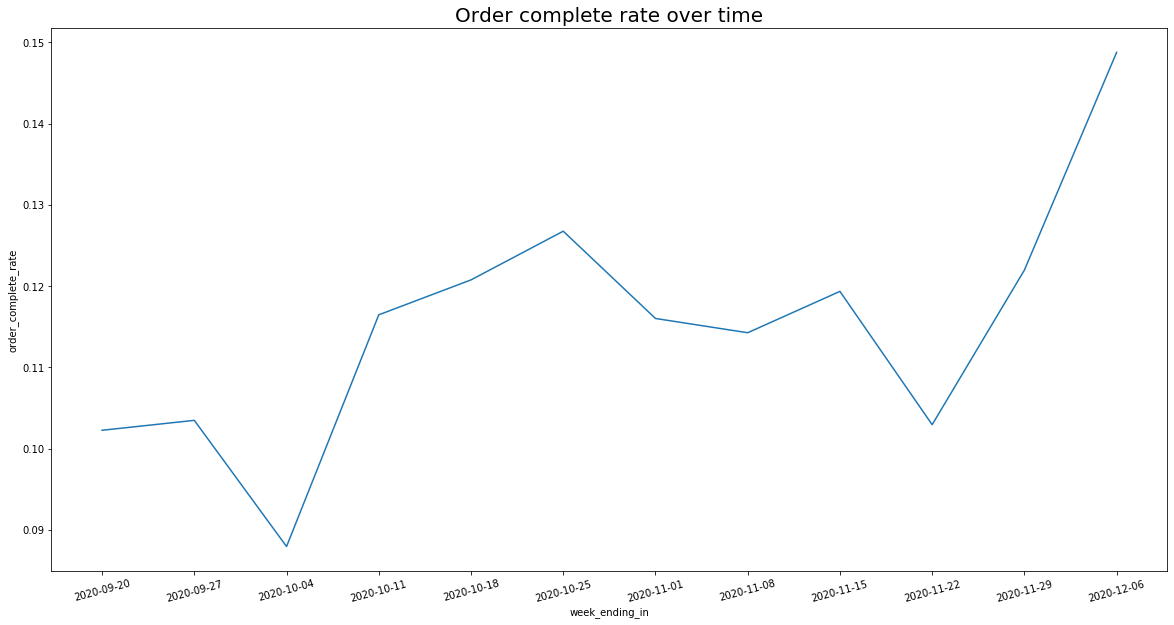

In [73]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=order_complete_rate['order_complete_rate'], x=order_complete_rate['week_ending_in'])
plt.xticks(order_complete_rate['week_ending_in'].values, rotation=15)
plt.title('Order complete rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric1.jpg", dpi=300)

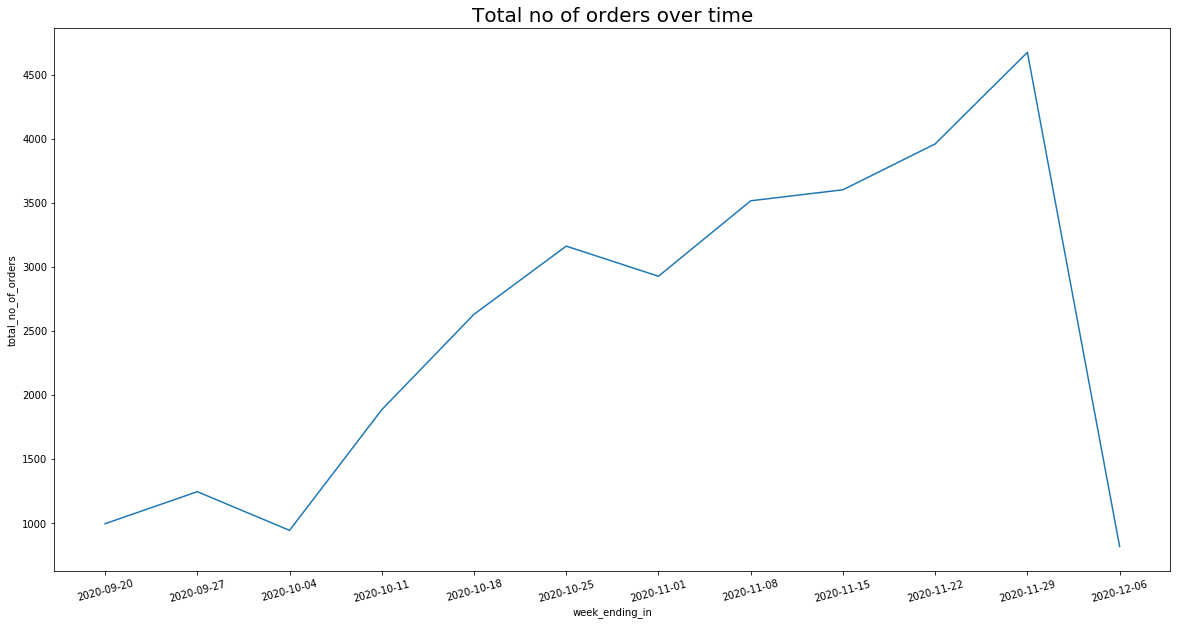

In [72]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=completed_orders['total_no_of_orders'], x=completed_orders['week_ending_in'])
plt.xticks(order_complete_rate['week_ending_in'].values, rotation=15)
plt.title('Total no of orders over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric2.jpg", dpi=300)

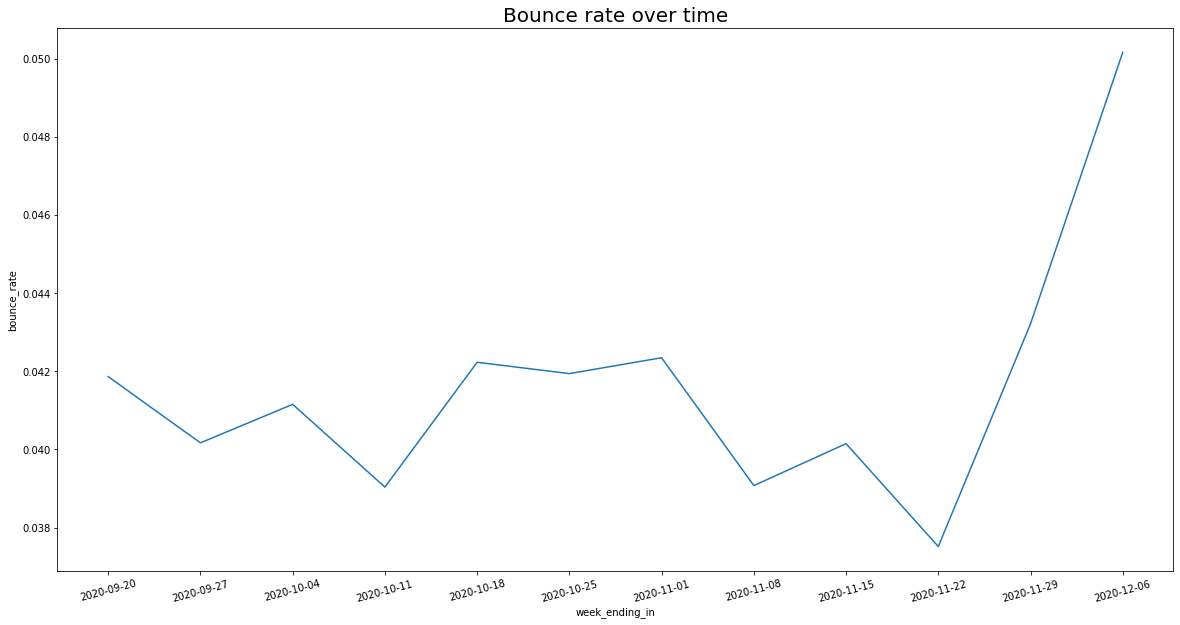

In [71]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=bounce_rate['bounce_rate'], x=bounce_rate['week_ending_in'])
plt.xticks(bounce_rate['week_ending_in'].values, rotation=15)
plt.title('Bounce rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric3.jpg", dpi=300)

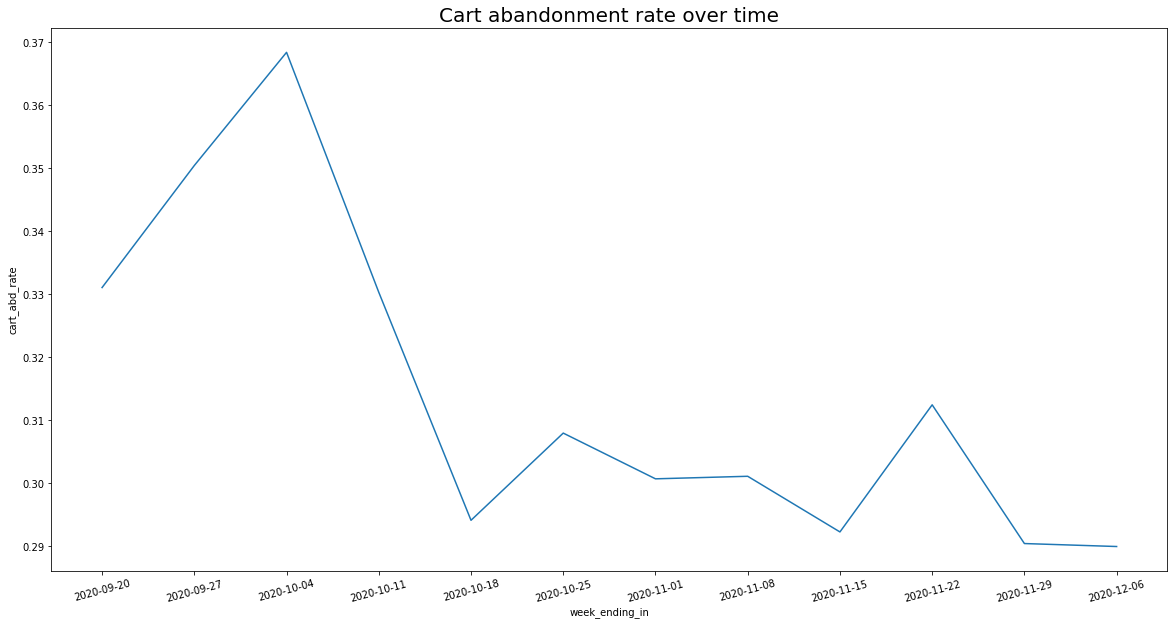

In [70]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=cart_abd_rate['cart_abd_rate'], x=cart_abd_rate['week_ending_in'])
plt.xticks(cart_abd_rate['week_ending_in'].values, rotation=15)
plt.title('Cart abandonment rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric4.jpg", dpi=300)